In [91]:
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Modeling
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [32]:
sentiment = pd.read_csv('daily_sentiment.csv')
sentiment['date'] = pd.to_datetime(sentiment['date'])
stock_universe = pd.read_pickle('stock_universe.pkl')

In [33]:
stocks = stock_universe[stock_universe.ticker.isin(['AMZN', 'AAPL', 'GOOG', 'MSFT','NVDA'])]
stocks.reset_index(drop = True, inplace = True)
stocks

,ticker,date,adj_close,adj_volume,return,Mkt-RF_beta,SMB_beta,HML_beta,RMW_beta,CMA_beta
0,AAPL,2018-01-09,41.320189,86335988.0,-0.000115,0.008756,-0.001232,-0.004926,-0.007597,-0.011452
1,AAPL,2018-01-10,41.310708,95839580.0,-0.000229,0.008775,-0.001056,-0.005217,-0.007099,-0.011424
2,AAPL,2018-01-11,41.545360,74670916.0,0.005680,0.007868,-0.000869,-0.005472,-0.007063,-0.011407
3,AAPL,2018-01-12,41.974372,101672320.0,0.010326,0.007796,-0.000790,-0.005381,-0.007251,-0.011504
4,AAPL,2018-01-16,41.761051,118263788.0,-0.005082,0.007936,-0.000954,-0.005445,-0.007099,-0.011467
...,...,...,...,...,...,...,...,...,...,...
6670,NVDA,2023-04-24,270.391139,32678946.0,-0.002839,0.011537,-0.007743,0.002696,-0.000870,-0.029270
6671,NVDA,2023-04-25,262.381994,36774922.0,-0.029621,0.011207,-0.007781,0.002511,-0.001182,-0.029258
6672,NVDA,2023-04-26,269.531231,40449391.0,0.027247,0.011268,-0.007532,0.002750,-0.001135,-0.029450
6673,NVDA,2023-04-27,272.230943,37426523.0,0.010016,0.011365,-0.007634,0.002580,-0.001063,-0.029480


In [37]:
df = stocks.merge(sentiment, how = 'outer',
                  left_on = ['date','ticker'],
                  right_on = ['date','ticker']).sort_values(by= ['ticker','date']).reset_index(drop = True)
df.sort_values(by= ['ticker','date'])

,ticker,date,adj_close,adj_volume,return,Mkt-RF_beta,SMB_beta,HML_beta,RMW_beta,CMA_beta,compound,neg,neu,pos,volume
0,AAPL,2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.255300,0.000000,0.854000,0.146000,2.0
1,AAPL,2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.064093,0.093143,0.815571,0.091286,14.0
2,AAPL,2018-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.048510,0.066100,0.894500,0.039400,10.0
3,AAPL,2018-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.173443,0.053857,0.784000,0.162143,7.0
4,AAPL,2018-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008500,0.068000,0.854200,0.078000,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9460,NVDA,2023-06-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.024525,0.028875,0.946125,0.025000,8.0
9461,NVDA,2023-06-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.170586,0.024643,0.853214,0.122143,14.0
9462,NVDA,2023-06-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.189127,0.097545,0.902455,0.000000,11.0
9463,NVDA,2023-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.121033,0.027222,0.888333,0.084444,9.0


After merging the stock data and related sentimental analysis, we can see a lot of missing values. This is because the stock market is closed on weekends and holidays, while the news is still being reported.

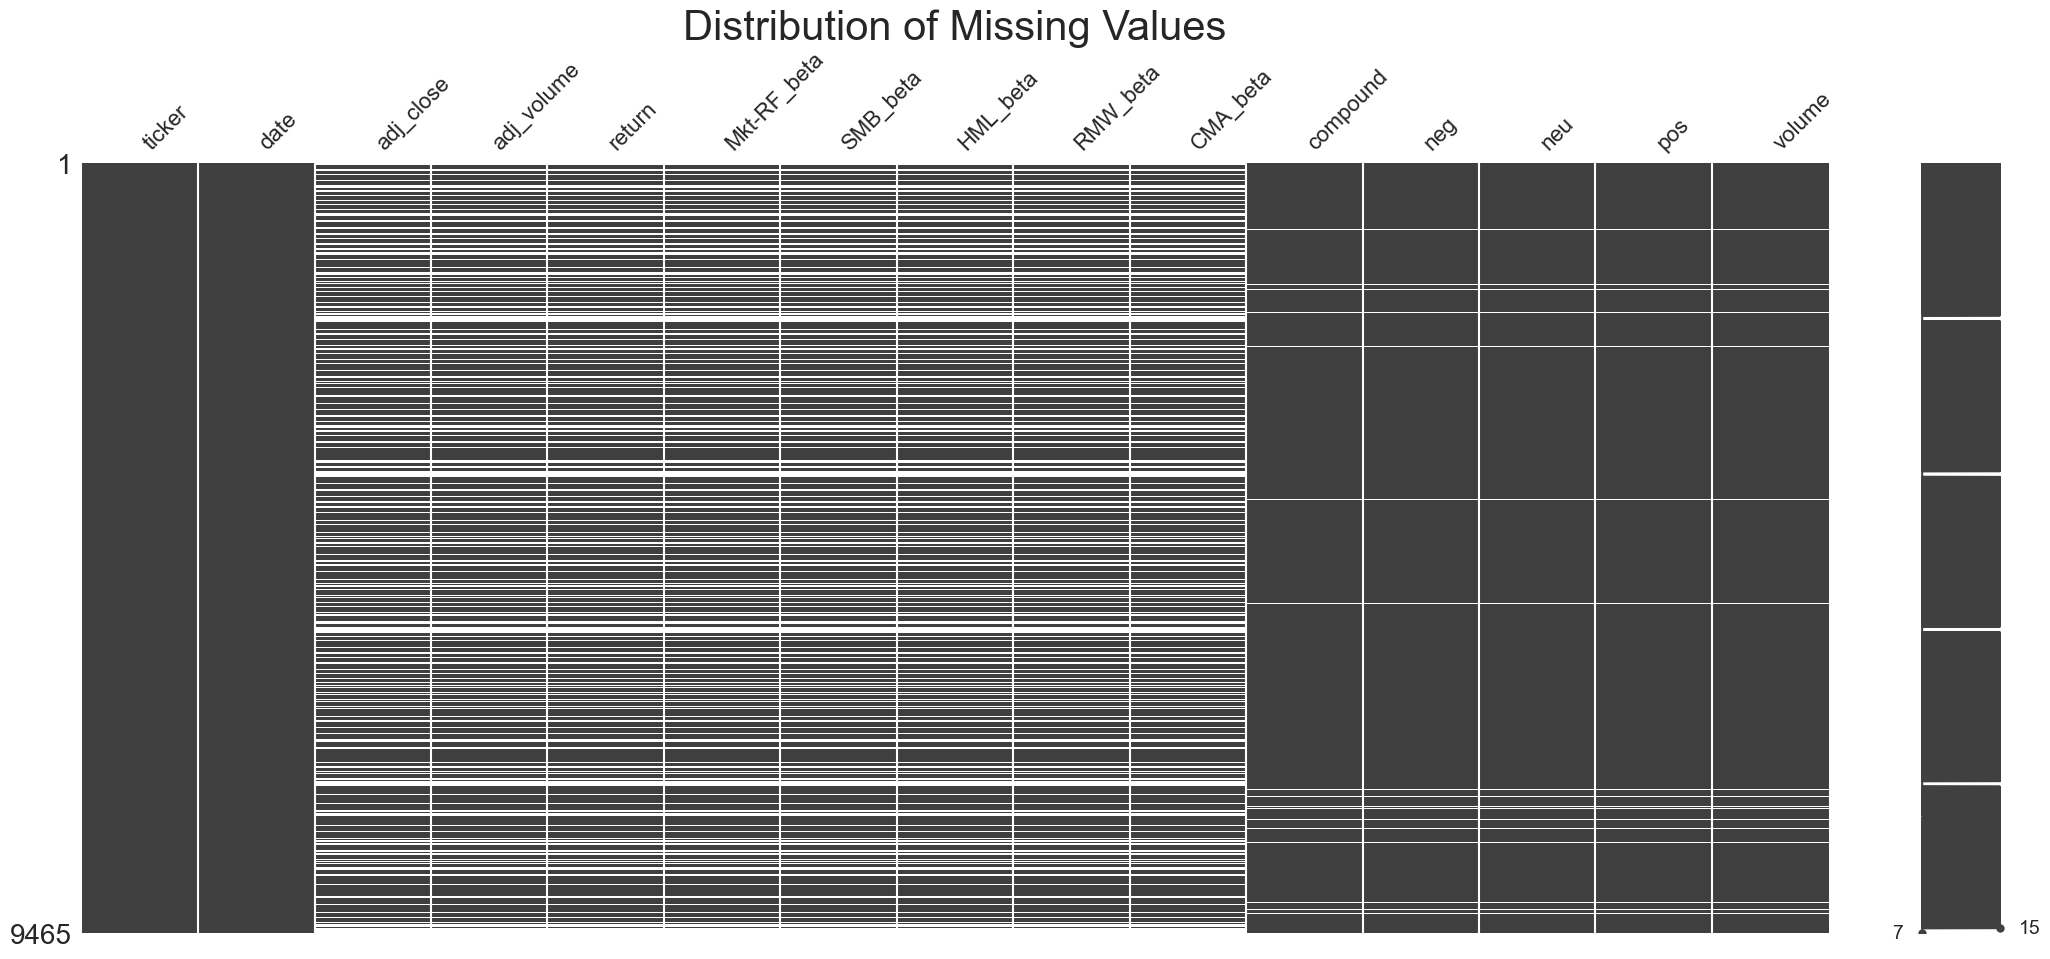

In [39]:
msno.matrix(df)
plt.title("Distribution of Missing Values", fontsize = 30)
None

Upon visualizing the missing values, it becomes evident that most of the gaps occur in stock data during weekends and holidays. Occasional missing values are also observed in news data. This implies that even though we have selected the most frequent and hot-spot companies, some firms' news might not be reported on certain days.

Nevertheless, since the market is closed during weekends and holidays, stock prices remain unchanged. In other words, all stock price information available to investors for analysis or speculation is from previous trading days. Consequently, we can utilize the stock price from the previous trading day to fill in the missing stock prices.

As for the news data, we can adopt a similar approach and use the previous day's news data to fill in the gaps while setting the volume to 0. Typically, the news sentiment from the previous day tends to be similar to that of the current day. Although sentiment may gradually become neutral over time, given the rarity of missing values, we can simplify the process by using the previous sentiment as a reliable proxy.

In [66]:
df.iloc[:,2:14] = df.iloc[:,2:14].fillna(method = 'ffill')
df.iloc[15] = df.iloc[15].fillna(0)
df = df.dropna()
df

,ticker,date,adj_close,adj_volume,return,Mkt-RF_beta,SMB_beta,HML_beta,RMW_beta,CMA_beta,compound,neg,neu,pos,volume
8,AAPL,2018-01-09,41.320189,86335988.0,-0.000115,0.008756,-0.001232,-0.004926,-0.007597,-0.011452,-0.108533,0.081889,0.898222,0.019889,9.0
9,AAPL,2018-01-10,41.310708,95839580.0,-0.000229,0.008775,-0.001056,-0.005217,-0.007099,-0.011424,0.026117,0.103500,0.791167,0.105333,6.0
10,AAPL,2018-01-11,41.545360,74670916.0,0.005680,0.007868,-0.000869,-0.005472,-0.007063,-0.011407,-0.053582,0.064909,0.872909,0.062182,11.0
11,AAPL,2018-01-12,41.974372,101672320.0,0.010326,0.007796,-0.000790,-0.005381,-0.007251,-0.011504,0.051225,0.069750,0.855125,0.075125,8.0
12,AAPL,2018-01-14,41.974372,101672320.0,0.010326,0.007796,-0.000790,-0.005381,-0.007251,-0.011504,-0.204700,0.110500,0.889500,0.000000,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9460,NVDA,2023-06-26,277.460384,29107979.0,0.019210,0.010289,-0.006635,0.002520,-0.001970,-0.029676,-0.024525,0.028875,0.946125,0.025000,8.0
9461,NVDA,2023-06-27,277.460384,29107979.0,0.019210,0.010289,-0.006635,0.002520,-0.001970,-0.029676,0.170586,0.024643,0.853214,0.122143,14.0
9462,NVDA,2023-06-28,277.460384,29107979.0,0.019210,0.010289,-0.006635,0.002520,-0.001970,-0.029676,-0.189127,0.097545,0.902455,0.000000,11.0
9463,NVDA,2023-06-29,277.460384,29107979.0,0.019210,0.010289,-0.006635,0.002520,-0.001970,-0.029676,0.121033,0.027222,0.888333,0.084444,9.0


In [67]:
summary_stats = df.describe()
summary_stats

,adj_close,adj_volume,return,Mkt-RF_beta,SMB_beta,HML_beta,RMW_beta,CMA_beta,compound,neg,neu,pos,volume
count,9258.000000,9.258000e+03,9258.000000,9258.000000,9258.000000,9258.000000,9258.000000,9258.000000,9258.000000,9258.000000,9258.000000,9258.000000,9258.000000
mean,126.997332,6.234553e+07,0.000692,0.011959,-0.002722,-0.003428,0.001805,-0.007368,0.079193,0.048876,0.845510,0.105615,6.147332
std,68.664335,4.821300e+07,0.023408,0.003057,0.003731,0.003868,0.005400,0.011889,0.170526,0.058267,0.101017,0.086152,3.947328
min,31.528513,6.935060e+06,-0.187559,0.000383,-0.016177,-0.019271,-0.020649,-0.045892,-0.824000,0.000000,0.303000,0.000000,1.000000
25%,72.866543,2.841904e+07,-0.010476,0.010209,-0.005165,-0.005720,-0.001219,-0.013786,0.000000,0.000000,0.783446,0.041571,3.000000
50%,112.799000,4.787815e+07,0.001051,0.011755,-0.002865,-0.003108,0.002206,-0.008551,0.070094,0.036000,0.856400,0.091950,6.000000
75%,160.193679,8.028166e+07,0.012172,0.013359,-0.000543,-0.000850,0.004958,-0.000855,0.172380,0.073229,0.914729,0.159000,9.000000
max,338.297561,4.184741e+08,0.171564,0.023148,0.009848,0.009202,0.023862,0.028699,0.942300,0.576000,1.000000,0.667000,39.000000


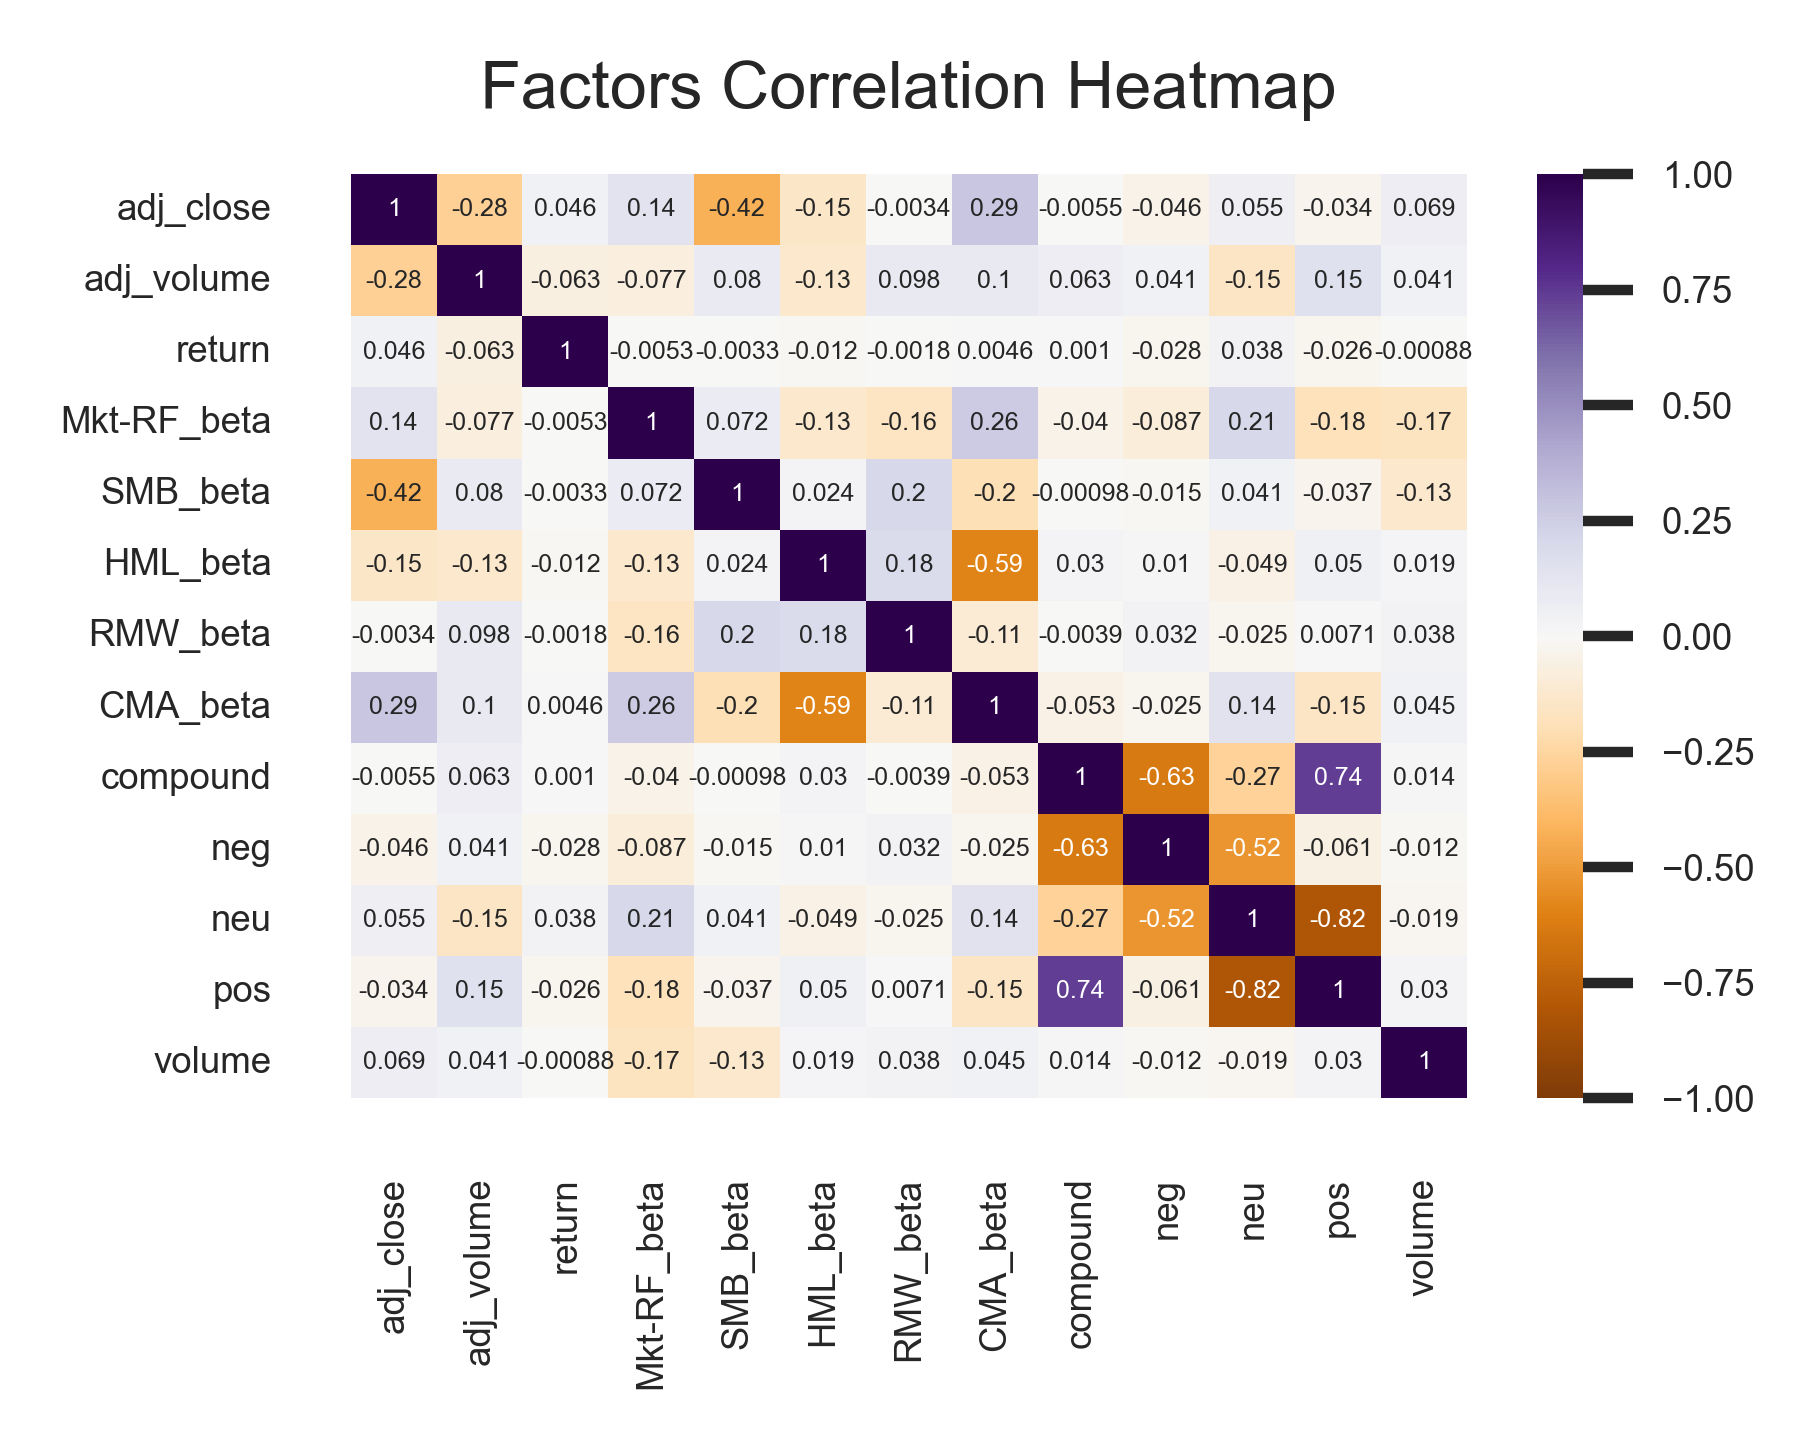

In [68]:
plt.figure(figsize=(3,2),dpi=600)
sns.set(font_scale=0.4)
heatmap = sns.heatmap(df.corr(), cmap="PuOr",vmin=-1, vmax=1, annot=True,annot_kws={"size": 3})
heatmap.set_title('Factors Correlation Heatmap', fontdict={'fontsize':8}, pad=8);

The correlation heatmap reveals a notable negative correlation between CMA beta and HML beta, raising concerns about potential collinearity in our future model. Interestingly, the heatmap also shows a correlation between neutral sentiment and market beta, indicating that the excess return of the equity is more likely to increase when the news sentiment is neutral. This return is defined by the risk premium of the equity itself.

Given that most factors exhibit low correlation, it seems reasonable to begin with a linear regression model. Notably, all betas are calculated based on the past 100 days, excluding today's closing price, while the news sentiment is available at the end of each day. This contemporaneous nature allows us to use a model to predict the return of the next day.

## Linear Regression Model

In [168]:
RMSE = []
MAE = []

In [148]:
def linear_regression(ticker, df):
    X_train = df[(df.ticker == ticker) & (df.date <= '2021-12-31')].loc[:,['adj_volume','Mkt-RF_beta','SMB_beta','HML_beta','RMW_beta','CMA_beta','compound','neg','neu','pos','volume']]
    y_train = df[(df.ticker == ticker) & (df.date <= '2021-12-31')].loc[:,'adj_close']
    X_test = df[(df.ticker == ticker) & (df.date >= '2022-01-01')].loc[:,['adj_volume','Mkt-RF_beta','SMB_beta','HML_beta','RMW_beta','CMA_beta','compound','neg','neu','pos','volume']]
    y_test = df[(df.ticker == ticker) & (df.date >= '2022-01-01')].loc[:,'adj_close']

    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    # fit the OLS regression model
    model = sm.OLS(y_train, X_train).fit()
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    df_OLS = pd.DataFrame({'Date' : df[(df.ticker == ticker) & (df.date >= '2022-01-01')].date, 'Actual': y_test, 'Predicted': y_pred})

    RMSE.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    MAE.append(mean_absolute_error(y_test, y_pred))
    print(model.summary())
    return df_OLS

In [169]:
AAPL_OLS = linear_regression('AAPL', df)
AAPL_OLS

                            OLS Regression Results                            
Dep. Variable:              adj_close   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     380.6
Date:                Fri, 21 Jul 2023   Prob (F-statistic):               0.00
Time:                        20:31:37   Log-Likelihood:                -6093.7
No. Observations:                1379   AIC:                         1.221e+04
Df Residuals:                    1367   BIC:                         1.227e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1730.6406   7732.865      0.224      

,Date,Actual,Predicted
1407,2022-01-01,176.032004,149.307339
1408,2022-01-02,176.032004,149.575819
1409,2022-01-03,180.433547,145.373134
1410,2022-01-04,178.143555,144.800656
1411,2022-01-05,173.404956,144.108974
...,...,...,...
1931,2023-06-27,169.444347,49.356585
1932,2023-06-28,169.444347,49.186755
1933,2023-06-29,169.444347,49.110524
1934,2023-06-30,169.444347,50.640280


In [170]:
AMZN_OLS = linear_regression('AMZN', df)
AMZN_OLS

                            OLS Regression Results                            
Dep. Variable:              adj_close   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     198.5
Date:                Fri, 21 Jul 2023   Prob (F-statistic):          6.35e-274
Time:                        20:31:39   Log-Likelihood:                -6301.6
No. Observations:                1379   AIC:                         1.263e+04
Df Residuals:                    1367   BIC:                         1.269e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -3822.1260   5233.958     -0.730      

,Date,Actual,Predicted
3335,2022-01-01,166.316431,153.588064
3336,2022-01-02,166.316431,153.522026
3337,2022-01-03,169.995071,152.697040
3338,2022-01-04,167.119496,153.017205
3339,2022-01-05,163.962101,154.133502
...,...,...,...
3845,2023-06-27,105.450000,103.423439
3846,2023-06-28,105.450000,102.671803
3847,2023-06-29,105.450000,103.293582
3848,2023-06-30,105.450000,102.047500


In [171]:
GOOG_OLS = linear_regression('GOOG', df)
GOOG_OLS

                            OLS Regression Results                            
Dep. Variable:              adj_close   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     144.7
Date:                Fri, 21 Jul 2023   Prob (F-statistic):          6.41e-220
Time:                        20:31:40   Log-Likelihood:                -6091.7
No. Observations:                1376   AIC:                         1.221e+04
Df Residuals:                    1364   BIC:                         1.227e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         820.2128   8404.565      0.098      

,Date,Actual,Predicted
5241,2022-01-01,144.6795,113.774262
5242,2022-01-02,144.6795,112.278378
5243,2022-01-03,145.0745,109.876416
5244,2022-01-04,144.4165,110.593472
5245,2022-01-05,137.6535,101.705018
...,...,...,...
5754,2023-06-26,108.2200,98.112489
5755,2023-06-27,108.2200,97.992111
5756,2023-06-28,108.2200,97.167178
5757,2023-06-29,108.2200,98.127982


In [172]:
MSFT_OLS = linear_regression('MSFT', df)
MSFT_OLS

                            OLS Regression Results                            
Dep. Variable:              adj_close   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     373.1
Date:                Fri, 21 Jul 2023   Prob (F-statistic):               0.00
Time:                        20:31:41   Log-Likelihood:                -6850.1
No. Observations:                1375   AIC:                         1.372e+04
Df Residuals:                    1363   BIC:                         1.379e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.096e+04   1.84e+04      2.766      

,Date,Actual,Predicted
7151,2022-01-01,331.602797,297.674904
7152,2022-01-02,331.602797,298.947570
7153,2022-01-03,330.054818,297.621193
7154,2022-01-04,324.395327,299.097273
7155,2022-01-05,311.942474,297.595233
...,...,...,...
7654,2023-06-27,306.596034,126.009625
7655,2023-06-28,306.596034,126.840568
7656,2023-06-29,306.596034,128.200433
7657,2023-06-30,306.596034,127.413802


In [173]:
NVDA_OLS = linear_regression('NVDA', df)
NVDA_OLS

                            OLS Regression Results                            
Dep. Variable:              adj_close   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     141.6
Date:                Fri, 21 Jul 2023   Prob (F-statistic):          3.68e-208
Time:                        20:31:42   Log-Likelihood:                -6393.8
No. Observations:                1218   AIC:                         1.281e+04
Df Residuals:                    1206   BIC:                         1.287e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1199.6433   1.35e+04     -0.089      

,Date,Actual,Predicted
8952,2022-01-03,300.852958,211.912361
8953,2022-01-04,292.552808,287.638021
8954,2022-01-05,275.712793,245.165257
8955,2022-01-06,281.445989,255.021199
8956,2022-01-07,272.147025,220.281567
...,...,...,...
9460,2023-06-26,277.460384,110.659016
9461,2023-06-27,277.460384,131.864539
9462,2023-06-28,277.460384,122.694930
9463,2023-06-29,277.460384,112.179141


### Plot the results

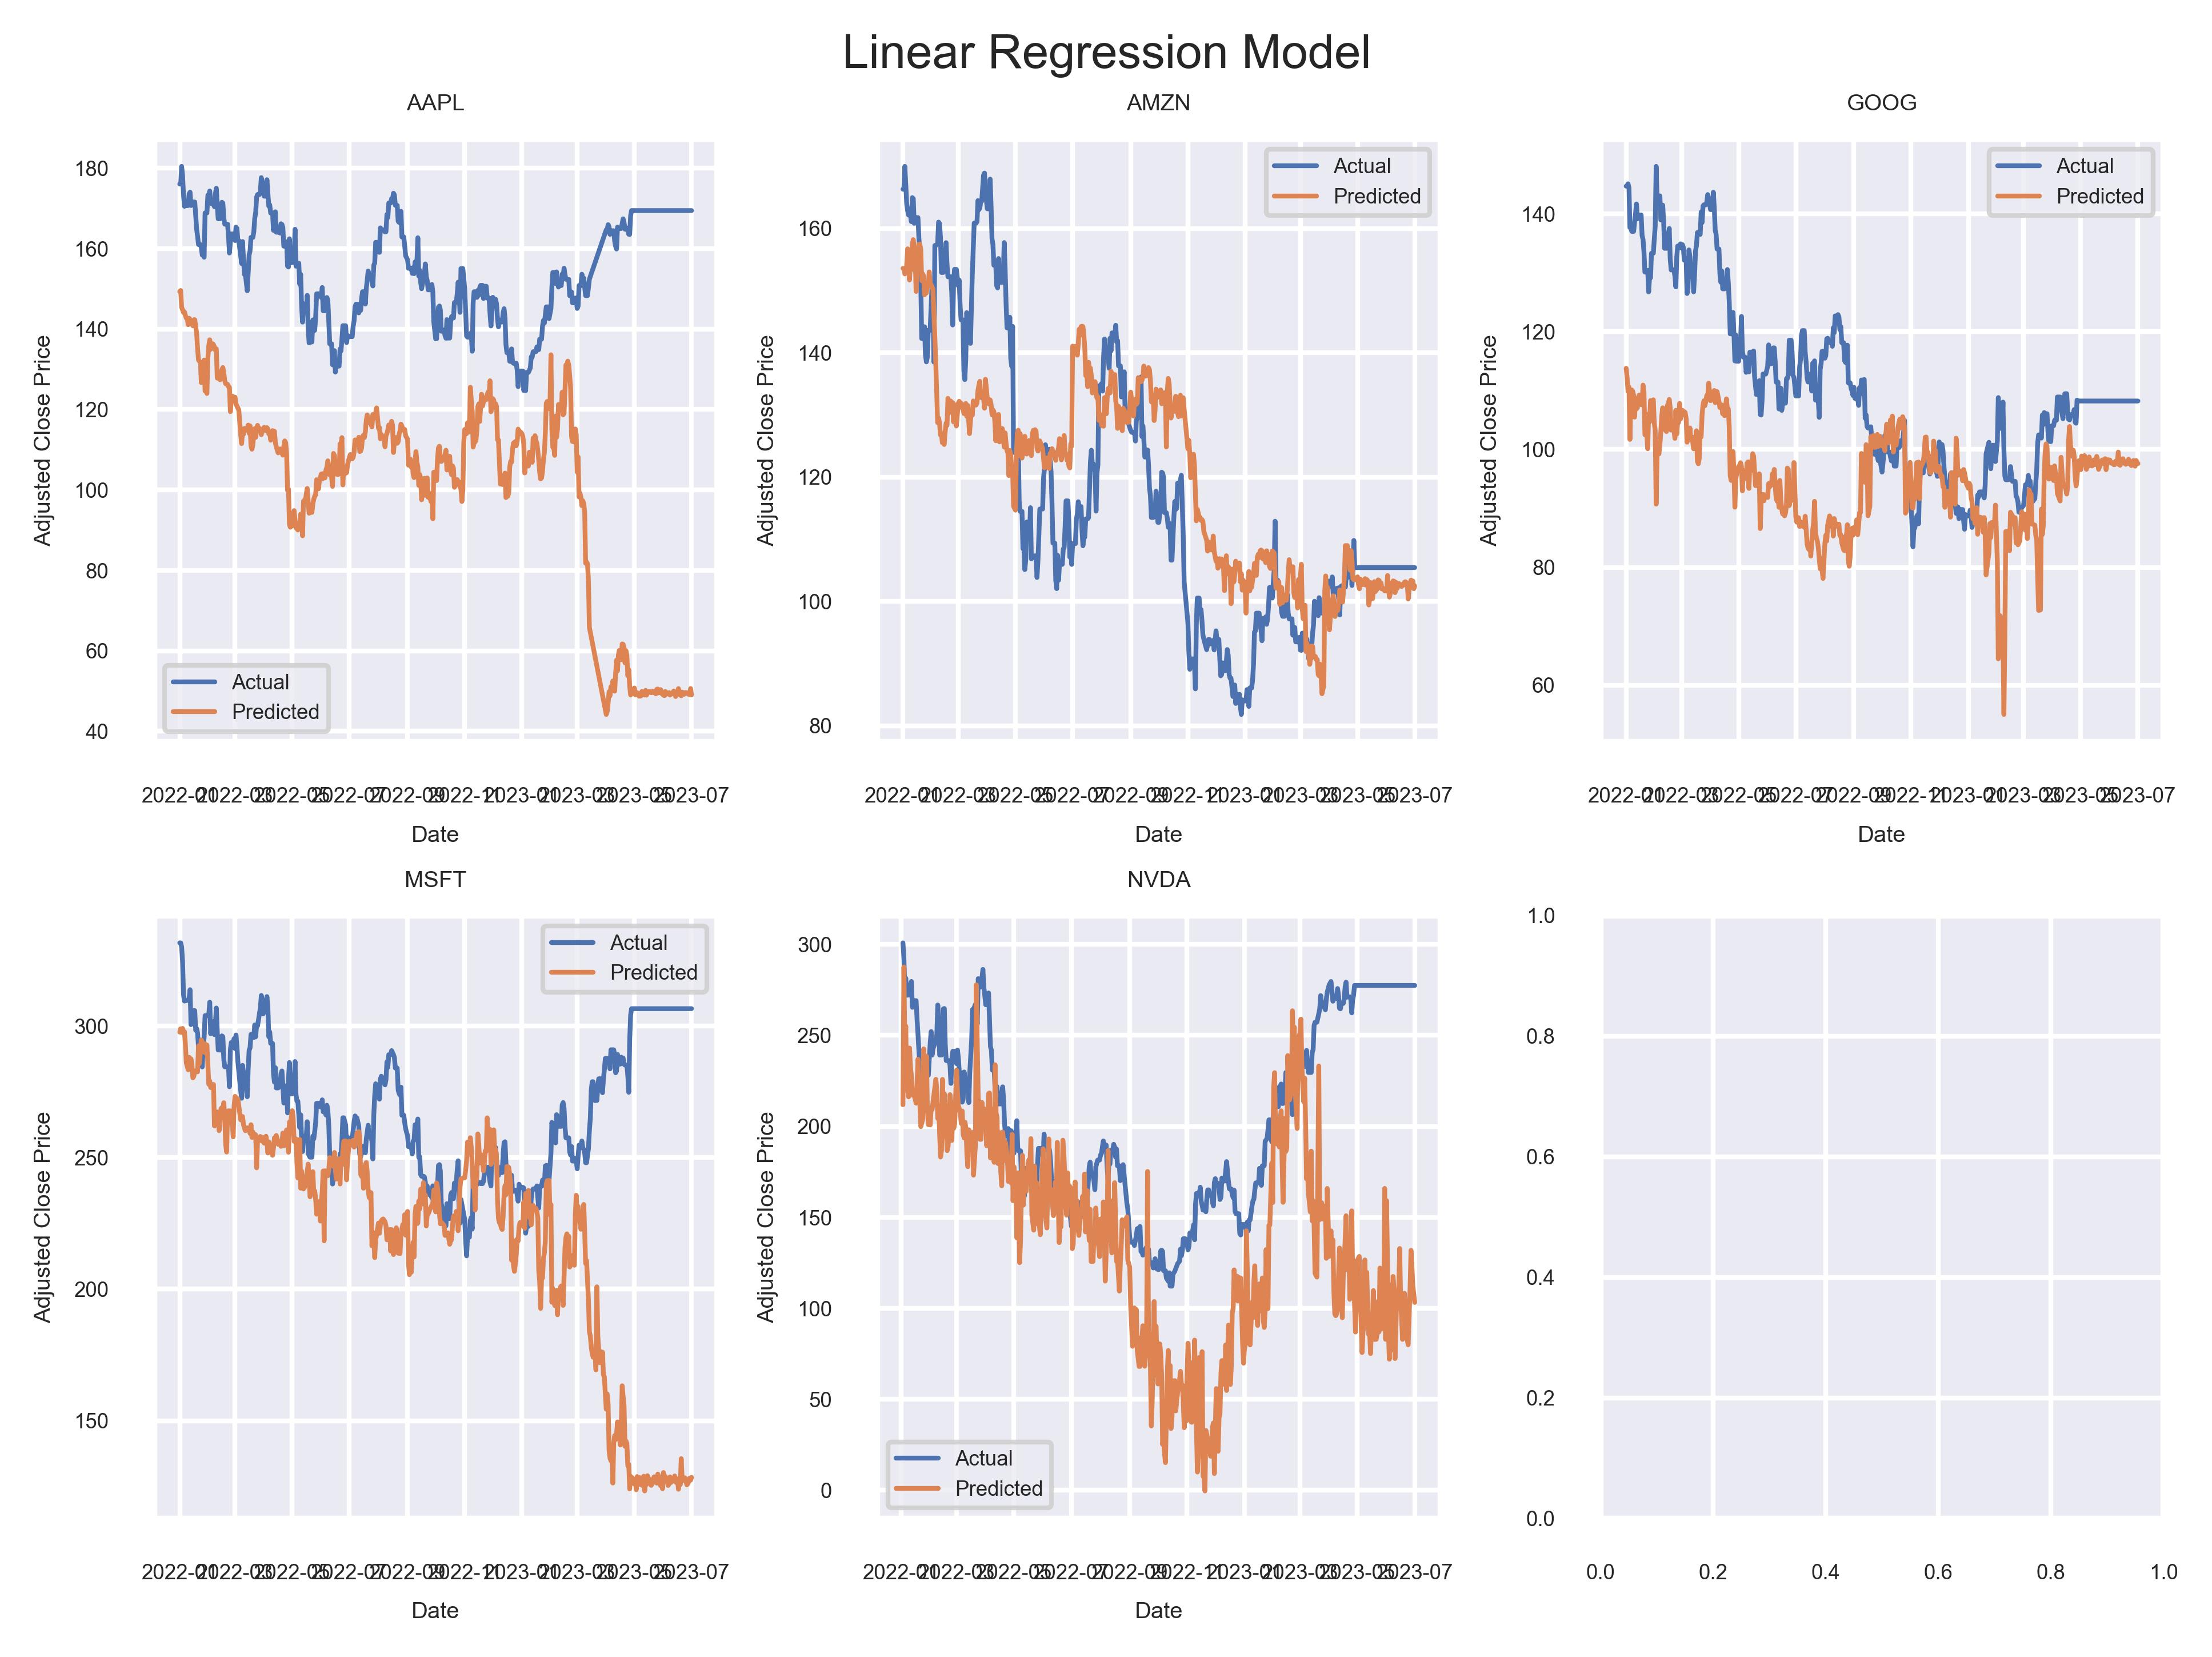

In [165]:
fig, axs = plt.subplots(2, 3, dpi = 600)

# Plot data1 on the first subplot (top-left)
axs[0, 0].plot(AAPL_OLS.Date, AAPL_OLS.Actual, label = 'Actual', linewidth=1)
axs[0, 0].plot(AAPL_OLS.Date, AAPL_OLS.Predicted, label = 'Predicted', linewidth=1)
axs[0, 0].set_title('AAPL')
axs[0, 0].legend()
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Adjusted Close Price')

axs[0, 1].plot(AMZN_OLS.Date, AMZN_OLS.Actual, label = 'Actual', linewidth=1)
axs[0, 1].plot(AMZN_OLS.Date, AMZN_OLS.Predicted, label = 'Predicted', linewidth=1)
axs[0, 1].set_title('AMZN')
axs[0, 1].legend()
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Adjusted Close Price')

axs[0, 2].plot(GOOG_OLS.Date, GOOG_OLS.Actual, label = 'Actual', linewidth=1)
axs[0, 2].plot(GOOG_OLS.Date, GOOG_OLS.Predicted, label = 'Predicted', linewidth=1)
axs[0, 2].set_title('GOOG')
axs[0, 2].legend()
axs[0, 2].set_xlabel('Date')
axs[0, 2].set_ylabel('Adjusted Close Price')

axs[1, 0].plot(MSFT_OLS.Date, MSFT_OLS.Actual, label = 'Actual', linewidth=1)
axs[1, 0].plot(MSFT_OLS.Date, MSFT_OLS.Predicted, label = 'Predicted', linewidth=1)
axs[1, 0].set_title('MSFT')
axs[1, 0].legend()
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Adjusted Close Price')

axs[1, 1].plot(NVDA_OLS.Date, NVDA_OLS.Actual, label = 'Actual', linewidth=1)
axs[1, 1].plot(NVDA_OLS.Date, NVDA_OLS.Predicted, label = 'Predicted', linewidth=1)
axs[1, 1].set_title('NVDA')
axs[1, 1].legend()
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Adjusted Close Price')

fig.suptitle('Linear Regression Model', fontsize=10)
plt.tight_layout()
plt.show()

In [190]:
OLS = pd.DataFrame({'Ticker' : ['AAPL', 'AMZN', 'GOOG', 'MSFT', 'NVDA'], 'RMSE_OLS': RMSE, 'MAE_OLS': MAE}).set_index('Ticker')
OLS

,RMSE_OLS,MAE_OLS
Ticker,,
AAPL,61.699579,53.009181
AMZN,15.334509,12.321666
GOOG,20.423012,16.852559
MSFT,78.039009,52.223114
NVDA,89.706018,69.882464


Based on the linear regression results, we observe a consistently strong fitted performance, as evidenced by R-Squared values exceeding 0.5 for all stocks. However, it is crucial to note that the predictive power varies across different equities due to their distinct standard deviations. Consequently, direct comparisons among tickers become impractical. To address this, we will utilize RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error) metrics to evaluate and compare the performance of various models.

## Random Forest Model

In [182]:
RMSE_RF = []
MAE_RF = []

In [183]:
def random_forest(ticker, df):
    X_train = df[(df.ticker == ticker) & (df.date <= '2021-12-31')].loc[:,['adj_volume','Mkt-RF_beta','SMB_beta','HML_beta','RMW_beta','CMA_beta','compound','neg','neu','pos','volume']].values
    y_train = df[(df.ticker == ticker) & (df.date <= '2021-12-31')].loc[:,'adj_close'].values
    X_test = df[(df.ticker == ticker) & (df.date >= '2022-01-01')].loc[:,['adj_volume','Mkt-RF_beta','SMB_beta','HML_beta','RMW_beta','CMA_beta','compound','neg','neu','pos','volume']].values
    y_test = df[(df.ticker == ticker) & (df.date >= '2022-01-01')].loc[:,'adj_close'].values

    rf_model = RandomForestRegressor(random_state=1)

    # Define the hyperparameters to tune
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Perform Grid Search to tune the best hyperparameters
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    best_rf_model = grid_search.best_estimator_

    best_hyperparams = grid_search.best_params_
    print("Best Hyperparameters:", best_hyperparams)

    y_pred = best_rf_model.predict(X_test)

    df_RF = pd.DataFrame({'Date' : df[(df.ticker == ticker) & (df.date >= '2022-01-01')].date, 'Actual': y_test, 'Predicted': y_pred})

    RMSE_RF.append(mean_squared_error(y_test, y_pred))
    MAE_RF.append(mean_absolute_error(y_test, y_pred))

    return df_RF

In [184]:
AAPL_RF = random_forest('AAPL', df)
AAPL_RF

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


,Date,Actual,Predicted
1407,2022-01-01,176.032004,176.243357
1408,2022-01-02,176.032004,176.347051
1409,2022-01-03,180.433547,174.830402
1410,2022-01-04,178.143555,173.561984
1411,2022-01-05,173.404956,174.959474
...,...,...,...
1931,2023-06-27,169.444347,46.993508
1932,2023-06-28,169.444347,46.828789
1933,2023-06-29,169.444347,46.955451
1934,2023-06-30,169.444347,46.831756


In [185]:
AMZN_RF = random_forest('AMZN', df)
AMZN_RF

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}


,Date,Actual,Predicted
3335,2022-01-01,166.316431,169.047303
3336,2022-01-02,166.316431,169.038396
3337,2022-01-03,169.995071,168.420522
3338,2022-01-04,167.119496,168.627491
3339,2022-01-05,163.962101,168.574426
...,...,...,...
3845,2023-06-27,105.450000,89.896204
3846,2023-06-28,105.450000,89.843912
3847,2023-06-29,105.450000,90.290360
3848,2023-06-30,105.450000,89.843912


In [186]:
GOOG_RF = random_forest('GOOG', df)
GOOG_RF

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


,Date,Actual,Predicted
5241,2022-01-01,144.6795,145.480239
5242,2022-01-02,144.6795,145.597689
5243,2022-01-03,145.0745,144.912464
5244,2022-01-04,144.4165,145.295872
5245,2022-01-05,137.6535,144.836517
...,...,...,...
5754,2023-06-26,108.2200,78.489428
5755,2023-06-27,108.2200,78.515995
5756,2023-06-28,108.2200,78.547824
5757,2023-06-29,108.2200,78.547824


In [187]:
MSFT_RF = random_forest('MSFT', df)
MSFT_RF

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}


,Date,Actual,Predicted
7151,2022-01-01,331.602797,330.925881
7152,2022-01-02,331.602797,330.666601
7153,2022-01-03,330.054818,328.662020
7154,2022-01-04,324.395327,328.035291
7155,2022-01-05,311.942474,325.088620
...,...,...,...
7654,2023-06-27,306.596034,132.916978
7655,2023-06-28,306.596034,134.107095
7656,2023-06-29,306.596034,134.095905
7657,2023-06-30,306.596034,132.857629


In [188]:
NVDA_RF = random_forest('NVDA', df)
NVDA_RF

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


,Date,Actual,Predicted
8952,2022-01-03,300.852958,295.538676
8953,2022-01-04,292.552808,292.290349
8954,2022-01-05,275.712793,283.658548
8955,2022-01-06,281.445989,283.571563
8956,2022-01-07,272.147025,305.550183
...,...,...,...
9460,2023-06-26,277.460384,225.728468
9461,2023-06-27,277.460384,225.721940
9462,2023-06-28,277.460384,225.557314
9463,2023-06-29,277.460384,225.952056


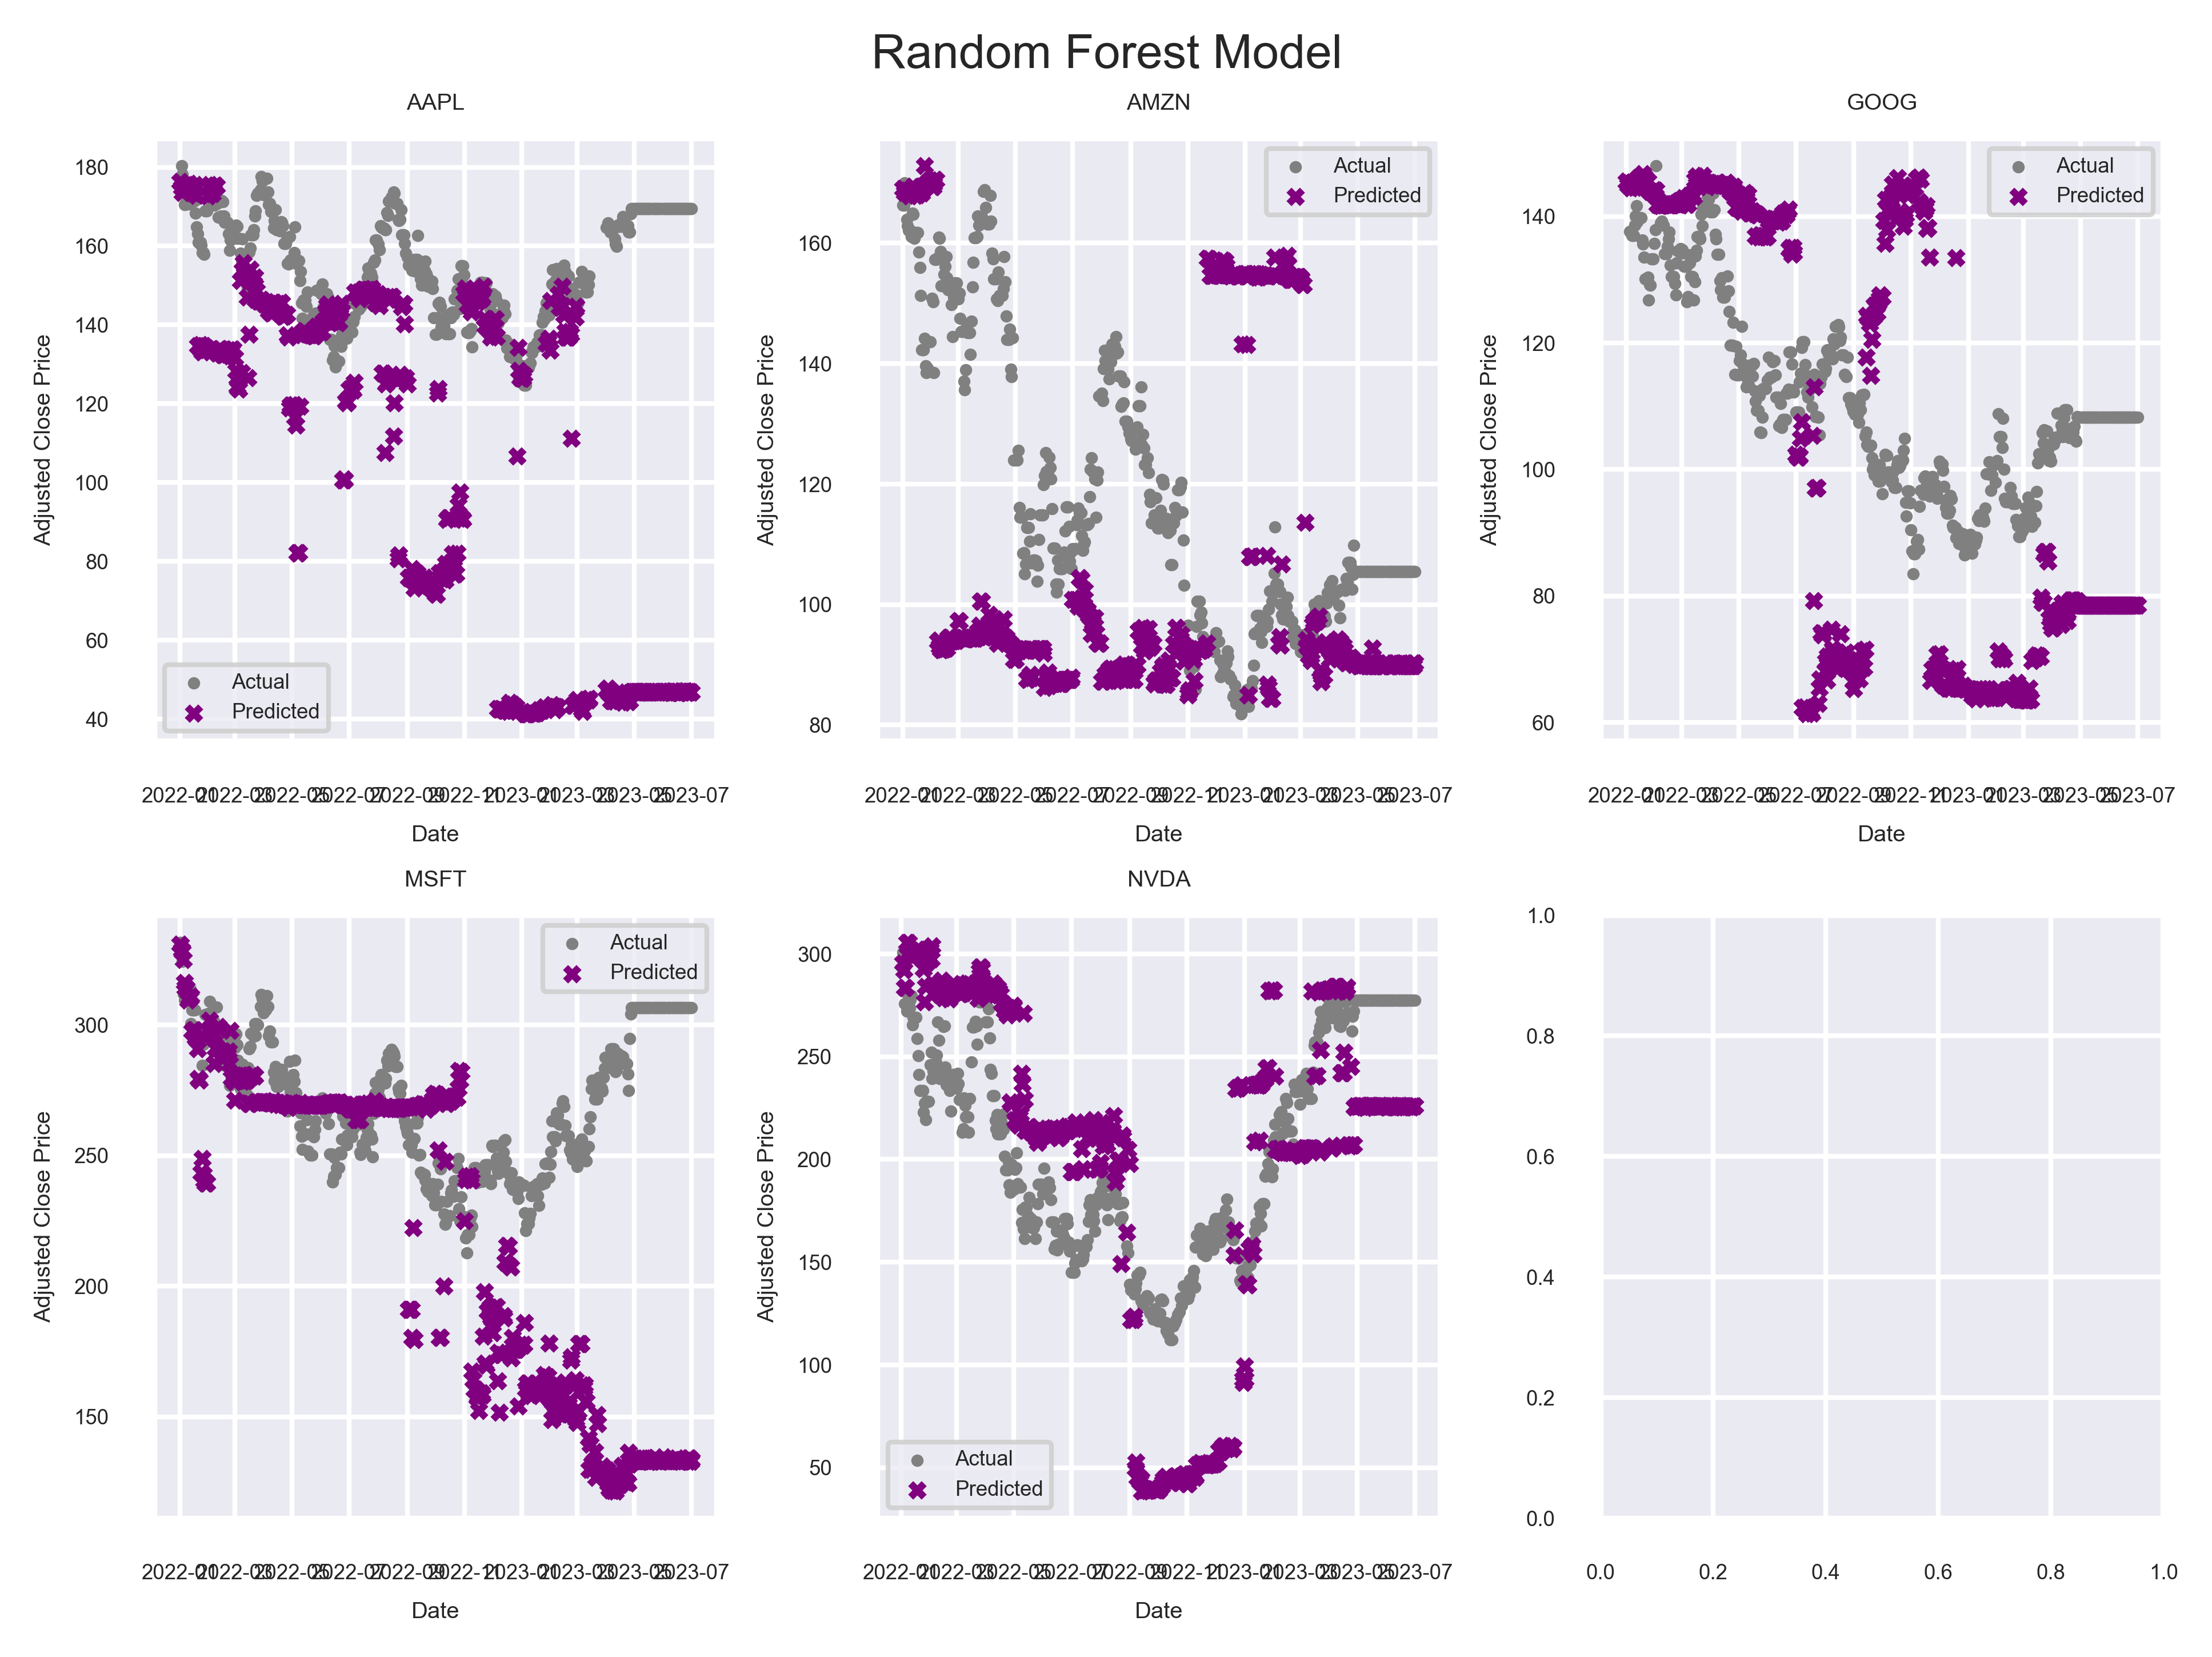

In [207]:
fig, axs = plt.subplots(2, 3, dpi = 600)

# Plot data1 on the first subplot (top-left)
axs[0, 0].scatter(AAPL_RF.Date, AAPL_RF.Actual, label = 'Actual', s=10, marker = '.', color = 'gray')
axs[0, 0].scatter(AAPL_RF.Date, AAPL_RF.Predicted, label = 'Predicted', s=8, marker = 'x', color = 'purple')
axs[0, 0].set_title('AAPL')
axs[0, 0].legend()
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Adjusted Close Price')

axs[0, 1].scatter(AMZN_RF.Date, AMZN_RF.Actual, label = 'Actual', s=10, marker = '.', color = 'gray')
axs[0, 1].scatter(AMZN_RF.Date, AMZN_RF.Predicted, label = 'Predicted', s=8, marker = 'x', color = 'purple')
axs[0, 1].set_title('AMZN')
axs[0, 1].legend()
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Adjusted Close Price')

axs[0, 2].scatter(GOOG_RF.Date, GOOG_RF.Actual, label = 'Actual', s=10, marker = '.', color = 'gray')
axs[0, 2].scatter(GOOG_RF.Date, GOOG_RF.Predicted, label = 'Predicted', s=8, marker = 'x', color = 'purple')
axs[0, 2].set_title('GOOG')
axs[0, 2].legend()
axs[0, 2].set_xlabel('Date')
axs[0, 2].set_ylabel('Adjusted Close Price')

axs[1, 0].scatter(MSFT_RF.Date, MSFT_RF.Actual, label = 'Actual', s=10, marker = '.', color = 'gray')
axs[1, 0].scatter(MSFT_RF.Date, MSFT_RF.Predicted, label = 'Predicted', s=8, marker = 'x', color = 'purple')
axs[1, 0].set_title('MSFT')
axs[1, 0].legend()
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Adjusted Close Price')

axs[1, 1].scatter(NVDA_RF.Date, NVDA_RF.Actual, label = 'Actual', s=10, marker = '.', color = 'gray')
axs[1, 1].scatter(NVDA_RF.Date, NVDA_RF.Predicted, label = 'Predicted', s=8, marker = 'x', color = 'purple')
axs[1, 1].set_title('NVDA')
axs[1, 1].legend()
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Adjusted Close Price')

fig.suptitle('Random Forest Model', fontsize=10)
plt.tight_layout()
plt.show()

In [211]:
RF = pd.DataFrame({'Ticker' : ['AAPL', 'AMZN', 'GOOG', 'MSFT', 'NVDA'], 'RMSE_RF' : RMSE_RF, 'MAE_RF' : MAE_RF}).set_index('Ticker')
RF

,RMSE_RF,MAE_RF
Ticker,,
AAPL,4642.324595,50.871377
AMZN,1508.005665,32.197857
GOOG,914.134802,27.223128
MSFT,7537.893105,62.433208
NVDA,3562.424556,51.869820


In [213]:
Accuracy = pd.concat([OLS, RF], axis=1)
Accuracy

,RMSE_OLS,MAE_OLS,RMSE_RF,MAE_RF
Ticker,,,,
AAPL,61.699579,53.009181,4642.324595,50.871377
AMZN,15.334509,12.321666,1508.005665,32.197857
GOOG,20.423012,16.852559,914.134802,27.223128
MSFT,78.039009,52.223114,7537.893105,62.433208
NVDA,89.706018,69.882464,3562.424556,51.869820


By comparing the predictive performance between OLS and Random Forest models, we can conclude that OLS is better than Random Forest in predicting the stock price.